In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor, wait
import preproc
import numpy as np
from tqdm import tqdm

csvPaths=[]
keywords=["filtered"]

for (dirpath,_,files) in os.walk(os.getcwd()):
    csvPaths += [os.sep.join((dirpath,filename)) 
                 for filename in files 
                 if (".csv" in filename.lower())
                 and
                 any(pattern.lower() in filename.lower() 
                     for pattern in keywords)
                ]
    
def loadcsv(path):
    df = pd.read_csv(path, sep=" ")
    
    assert len(df.columns) == 5
    assert len(df.index) > 1
    
    dimens = df.columns.astype(np.float64).tolist() 
    
    df.iloc[:,2], df.iloc[:,1], df.iloc[:,3] = preproc.transcoor(
        df.iloc[:,2]*416, df.iloc[:,1]*416, 416, 416, dimens[3], dimens[4], 
        dimens[1], dimens[2], df.iloc[:,3]
    )
    
    return df.iloc[:,1:4].to_dict('split')['data']
    
    
with ThreadPoolExecutor(max_workers=min(os.cpu_count()+4, len(csvPaths))) as executor:
    futures = []
    dfList=[]
    for path in tqdm(csvPaths):
        futures.append(executor.submit(loadcsv, path))

    done,_ = wait(futures)

    for future in done:
        try:
            dfList += future.result()
        except:
            continue
            
pd.DataFrame(dfList, columns=['Lat', 'Long', 'Radius (km)'])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:00<00:00, 18079.53it/s]


,Lat,Long,Radius (km)
0,40.8841,-36.136,4.58489
1,39.3701,-37.515,6.48601
2,40.3132,-36.766,5.36438
3,40.0025,-36.410,5.85553
4,40.4537,-36.428,11.75110
...,...,...,...
89562,26.8930,-94.102,7.61676
89563,26.8270,-94.353,6.99264
89564,-25.5947,-45.190,12.65840
89565,-25.9546,-45.490,3.14358


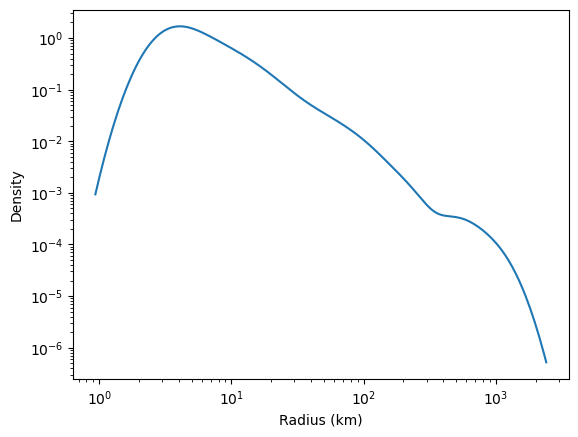

In [47]:
import seaborn as sns
ax = sns.kdeplot(pd.DataFrame(dfList, columns=['Lat', 'Long', 'Radius (km)'])['Radius (km)'], log_scale=(True,True), bw_adjust=5)


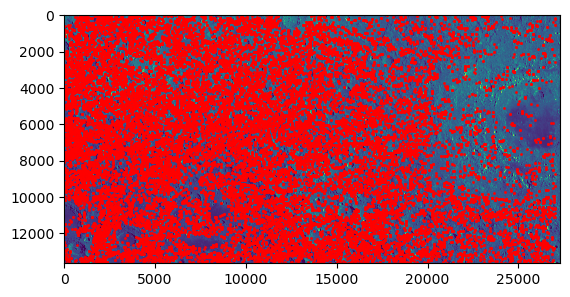

In [14]:
import pygmt
from numpy import asarray
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

imgarr = asarray(Image.open('data/Moon_WAC_Training/Moon_WAC_Training/images/Lunar_A.jpg'))
craterdf = pd.DataFrame(dfList, columns=['Lat', 'Long', 'Radius'])
craterdf = craterdf[(craterdf.Long > -180) & (craterdf.Long < -90) &
                    (craterdf.Lat > -45) & (craterdf.Lat < 0)]
craterdf.Long, craterdf.Lat, craterdf.Radius = preproc.revtranscoor(
    craterdf.Long, craterdf.Lat, imgarr.shape[1], imgarr.shape[0],
    -180, -90, 0, -45, craterdf.Radius
)

x = craterdf.Long.tolist()
y = craterdf.Lat.tolist()
w = craterdf.Radius.tolist()
h = w

fig, ax = plt.subplots() 
ax.imshow(imgarr)
ax.plot(x, y, 'r.', markersize=2)
plt.show()